In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [371]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklego.metrics import p_percent_score
from statistics import mean
from sklego.metrics import equal_opportunity_score

In [372]:
from sklego.preprocessing import InformationFilter
from sklearn.model_selection import RandomizedSearchCV

In [373]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import RFE
from sklego.linear_model import DemographicParityClassifier
from sklego.linear_model import EqualOpportunityClassifier

In [374]:
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [375]:
from shap import LinearExplainer, summary_plot

In [376]:
import ipywidgets

In [377]:
# protected attributes: race and sex
cols = ["age", "workclass", "fnlwgt", "education", "educational-num", "marital-status", "occupation", "relationship", "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

In [378]:
# load data
df = pd.read_csv("/Users/jobo/Desktop/WellsFargo/adult.csv.zip", header=0, delimiter=',')

In [379]:
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [380]:
df.shape

(48842, 15)

In [381]:
num_features = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [382]:
cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'native-country']

## Data Cleaning

### Handling Missing Data

In [383]:
# format of missing data:
question_mark = df.loc[4, 'workclass']

In [384]:
# find features that have missing data
features_missing_data = {}
indices_missing_data = []
for index, row in df.iterrows():
    for col in cols:
        if row[col] == question_mark:
            indices_missing_data.append(index)
            if col in features_missing_data:
                features_missing_data[col] += 1
            else:
                features_missing_data[col] = 1

In [385]:
# nativecountry, workclass, and occupation are the 3 features that contain missing data
features_missing_data

{'workclass': 2799, 'occupation': 2809, 'native-country': 857}

In [386]:
# check what percentage of rows have missing data
percent_rows_missing_data = len(set(indices_missing_data))/df.shape[0]
percent_rows_missing_data

0.07411653904426518

Note: ~7% of the rows having missing data. Three main options come to mind for how to handle this missing data:
1. Remove missing data 
2. Replace missing data with most frequent values from that column (given that all three features with missing data are categorical)
3. Replace missing data such that the distribution of the missing dataset closely resembles the distribution of the non-missing dataset

Lets check how the distributions of gender, income, and race in the missing data compare to that of the original data

In [387]:
indices_missing_unique = list(set(indices_missing_data))

In [388]:
df_missing_data = df.iloc[indices_missing_unique]

### Distribution of gender in missing dataset

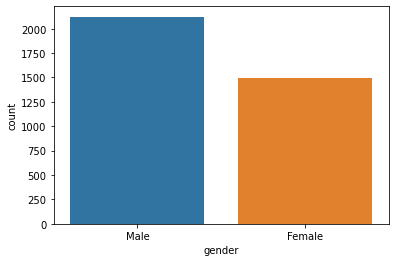

In [389]:
sns.countplot(x="gender", data= df_missing_data)
plt.show()

### Distribution of gender in original dataset

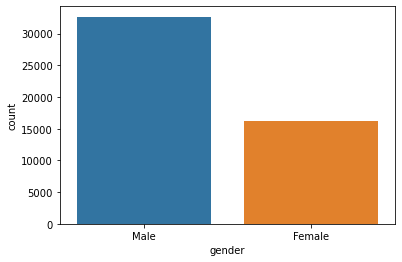

In [390]:
sns.countplot(x="gender", data= df)
plt.show()

### Distribution of income in missing dataset

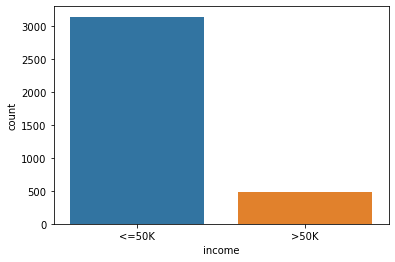

In [391]:
sns.countplot(x="income", data= df_missing_data)
plt.show()

### Distribution of income in original dataset

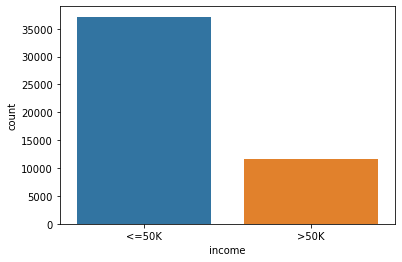

In [392]:
sns.countplot(x="income", data= df)
plt.show()

### Distribution of race in missing dataset

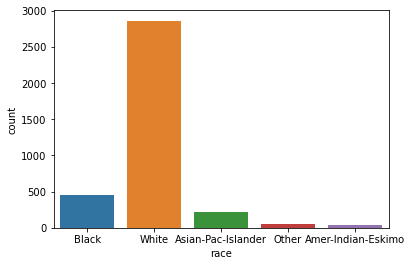

In [393]:
sns.countplot(x="race", data= df_missing_data)
plt.show()

### Distribution of race in original dataset

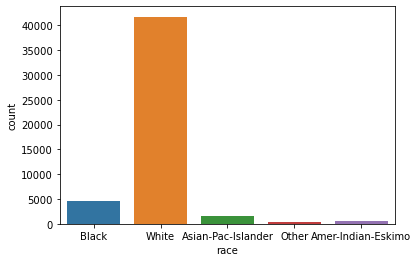

In [394]:
sns.countplot(x="race", data= df)
plt.show()

The distribution of the gender, income, and race in the missing datasets are similar enough to the respective distributions of the original dataset. For this reason, as well as the fact that a relatively small portion of the rows have missing values (~7%), I will remove the rows with missing data.

In [395]:
# remove rows which contain missing data
df = df.drop(df[df.workclass == question_mark].index)
df = df.drop(df[df.occupation == question_mark].index)
df = df.drop(df[df["native-country"] == question_mark].index)

In [396]:
df.shape

(45222, 15)

## Feature Engineering

In [397]:
df['education'].value_counts()

HS-grad         14783
Some-college     9899
Bachelors        7570
Masters          2514
Assoc-voc        1959
11th             1619
Assoc-acdm       1507
10th             1223
7th-8th           823
Prof-school       785
9th               676
12th              577
Doctorate         544
5th-6th           449
1st-4th           222
Preschool          72
Name: education, dtype: int64

In [398]:
df['educational-num'].value_counts()

9     14783
10     9899
13     7570
14     2514
11     1959
7      1619
12     1507
6      1223
4       823
15      785
5       676
8       577
16      544
3       449
2       222
1        72
Name: educational-num, dtype: int64

Educational number and education are essentially providing the same information. For this reason, and remove education. I choose to remove education because I would rather have a continuous variable than a categorical variable that I would need to one-hot encode.

In [399]:
# remove education feature
df = df.drop('education', 1)

### Marital-Status

In [400]:
df['marital-status'].value_counts()

Married-civ-spouse       21055
Never-married            14598
Divorced                  6297
Separated                 1411
Widowed                   1277
Married-spouse-absent      552
Married-AF-spouse           32
Name: marital-status, dtype: int64

In order to make one-hot encoding simpler, I will condense marital-status into the following four categories:
1. married ( Married-civ-spouse, Married-spouse-absent, Married-AF-spouse)
2. separated (Divorced, Separated)
3. never-married
4. widowed

In [401]:
married= ['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse']
separated  = ['Divorced', 'Separated']

df['marital-status'].replace(to_replace = married ,value = 'Married',inplace = True)
df['marital-status'].replace(to_replace = separated,value = 'Separated',inplace = True)

In [402]:
df['marital-status'].value_counts()

Married          21639
Never-married    14598
Separated         7708
Widowed           1277
Name: marital-status, dtype: int64

### Workclass

In [403]:
df['workclass'].value_counts()

Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Name: workclass, dtype: int64

I will condense workclass into the following 3 categories:
1. Self-employed (Self-emp-not-inc, Self-emp-inc)
2. Government (Local-gov, State-gov, Federal-gov)
3. Private
4. Without-pay

In [404]:
self_employed = ['Self-emp-not-inc','Self-emp-inc']
government_employees = ['Local-gov','State-gov','Federal-gov']

df['workclass'].replace(to_replace = self_employed ,value = 'Self_employed',inplace = True)
df['workclass'].replace(to_replace = government_employees,value = 'Govt_employees',inplace = True)

In [405]:
df['workclass'].value_counts()

Private           33307
Govt_employees     6452
Self_employed      5442
Without-pay          21
Name: workclass, dtype: int64

### Native country

In [406]:
df['native-country'].value_counts()

United-States                 41292
Mexico                          903
Philippines                     283
Germany                         193
Puerto-Rico                     175
Canada                          163
El-Salvador                     147
India                           147
Cuba                            133
England                         119
China                           113
Jamaica                         103
South                           101
Italy                           100
Dominican-Republic               97
Japan                            89
Guatemala                        86
Vietnam                          83
Columbia                         82
Poland                           81
Haiti                            69
Portugal                         62
Iran                             56
Taiwan                           55
Greece                           49
Nicaragua                        48
Peru                             45
Ecuador                     

Given that each country outside of US accounts for less than 2% of the dataset, I will condense these category into the following 2 categories:
1. US
2. Not US

In [407]:
not_us = []
for country in df['native-country'].unique():
    if country != 'United-States':
        not_us.append(country)
df['native-country'].replace(to_replace = not_us ,value = 'Not United-States',inplace = True)

In [408]:
df['native-country'].value_counts()

United-States        41292
Not United-States     3930
Name: native-country, dtype: int64

### Race

For the purposes of this exploration, we will only be considering the following races: 
1. White
2. Black

In [409]:
df['race'].value_counts()

White                 38903
Black                  4228
Asian-Pac-Islander     1303
Amer-Indian-Eskimo      435
Other                   353
Name: race, dtype: int64

In [410]:
df.drop(df.loc[df['race'] == 'Asian-Pac-Islander'].index, inplace=True)
df.drop(df.loc[df['race'] == 'Amer-Indian-Eskimo'].index, inplace=True)
df.drop(df.loc[df['race'] == 'Other'].index, inplace=True)

In [411]:
df['race'].value_counts()

White    38903
Black     4228
Name: race, dtype: int64

In [412]:
# convert race into a binary column
df['race'] = LabelEncoder().fit_transform(df['race'])

In [413]:
df['race'].value_counts()

1    38903
0     4228
Name: race, dtype: int64

In [414]:
# convert categorical variables into numerical variables through one-hot encoding
df = pd.get_dummies(df, columns = cat_features)

In [415]:
# convert gender into a binary column
df['gender'] = LabelEncoder().fit_transform(df['gender'])
# convert income label into a binary column
df['income'] = LabelEncoder().fit_transform(df['income'])

In [416]:
# scale numerical data
df_copy = df.copy()
df[num_features] = StandardScaler().fit_transform(df[num_features])

In [420]:
x = df.drop('income', axis = 1)

In [421]:
y = df.income

In [422]:
# used to compute p_percent_score
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Modeling

In [423]:
# classifiers
classifiers=['Logistic Regression', 'Demographic Parity']

In [424]:
models=[LogisticRegression(max_iter=5000),DemographicParityClassifier(sensitive_cols=['gender'], covariance_threshold=0.0000069)]

In [425]:
# define cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [426]:
# model evaluation metrics 
mean_accuracy=[]
mean_precision=[]
mean_recall=[]
accuracy_std=[]
p_percents_sex=[]

In [427]:
for model in models:
    # accuracy
    cv_accuracy = cross_val_score(model,x,y,scoring = "accuracy", cv = cv, n_jobs=-1)
    # precision
    cv_precision = cross_val_score(model, x, y, scoring='precision', cv=cv, n_jobs=-1)
    # recall
    cv_recall = cross_val_score(model, x, y, scoring='recall', cv=cv, n_jobs=-1)
    #p% 
    model.fit(xtrain, ytrain)
    p_percent_sex = p_percent_score(sensitive_column="gender")(model, xtest, ytest)
    
    mean_accuracy.append(mean(cv_accuracy))
    accuracy_std.append(cv_accuracy.std())
    mean_precision.append(mean(cv_precision))
    mean_recall.append(mean(cv_recall))
    p_percents_sex.append(p_percent_sex)

In [428]:
models_dataframe=pd.DataFrame({'Mean Accuracy':mean_accuracy, 'Accuracy Std':accuracy_std, 'Mean Precision':mean_precision, 'Mean Recall':mean_recall,  'P% sex':p_percents_sex},index=classifiers)

## Benchmark results

In [429]:
df['gender'].value_counts()

1    29164
0    13967
Name: gender, dtype: int64

In [430]:
df.groupby(['gender','income']).size()

gender  income
0       0         12386
        1          1581
1       0         20004
        1          9160
dtype: int64

Baseline comparison for p percentage relative to gender: if our model was 100% accurate, the following would be our p percent score for gender:

In [431]:
# positive outcome female / total female
p_y1_z0 = 1581/13967
# positive outcome male / total male 
p_y1_z1 = 9160/29164
dataset_p_percent = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
dataset_p_percent

0.36039632408643835

In [432]:
models_dataframe

,Mean Accuracy,Accuracy Std,Mean Precision,Mean Recall,P% sex
Logistic Regression,0.847001,0.003757,0.734250,0.604507,0.287016
Demographic Parity,0.831567,0.003065,0.728192,0.516464,0.797039


## Exploration of Covariance Threshold Hyperparameter for Demographic Parity Classifier

In [433]:
dpc_clf = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=0.5)

In [434]:
grid_dpc = GridSearchCV(estimator=dpc_clf, param_grid={"estimator__covariance_threshold":np.linspace(0, 1.00, 40)}, cv=5, return_train_score=True, refit="p_percent_score", scoring={"p_percent_score":p_percent_score('gender'), "accuracy_score":make_scorer(accuracy_score)})

In [435]:
grid_dpc.fit(x,y)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=_DemographicParityClassifier(covariance_threshold=0.5,
                                                                                  sensitive_cols='gender'),
                                           n_jobs=1),
             param_grid={'estimator__covariance_threshold': array([0.        , 0.02564103, 0.05128205, 0.07692308, 0.1025641 ,
       0.12820513, 0.15384615, 0.17948718, 0.20512821, 0.23076923,
       0.25641026, 0.28205128, 0.30769231, 0.33333333, 0.358...
       0.51282051, 0.53846154, 0.56410256, 0.58974359, 0.61538462,
       0.64102564, 0.66666667, 0.69230769, 0.71794872, 0.74358974,
       0.76923077, 0.79487179, 0.82051282, 0.84615385, 0.87179487,
       0.8974359 , 0.92307692, 0.94871795, 0.97435897, 1.        ])},
             refit='p_percent_score', return_train_score=True,
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'p_percent_score': <function

In [436]:
results_dpc = (pd.DataFrame(grid_dpc.cv_results_).set_index("param_estimator__covariance_threshold"))

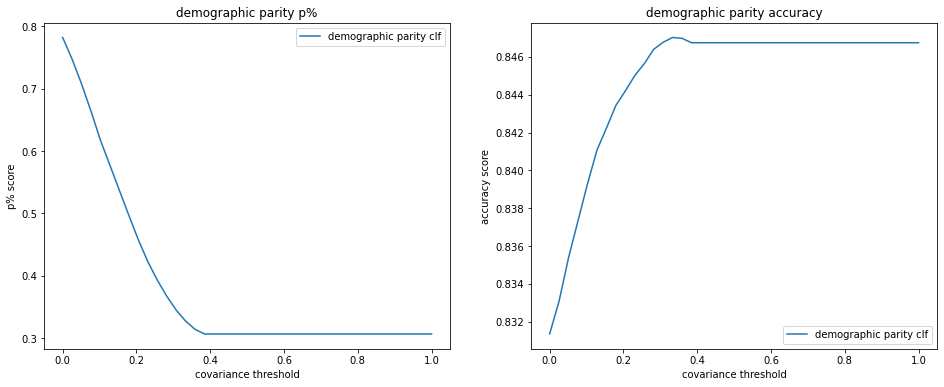

In [437]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(np.array(results_dpc.index), results_dpc['mean_test_p_percent_score'], label='demographic parity clf')
plt.xlabel("covariance threshold")
plt.ylabel('p% score')
plt.legend()
plt.title("demographic parity p%")
plt.subplot(122)
plt.plot(np.array(results_dpc.index), results_dpc['mean_test_accuracy_score'], label='demographic parity clf')
plt.xlabel("covariance threshold")
plt.ylabel('accuracy score')
plt.legend()
plt.title("demographic parity accuracy");

## Approach 1:  Exploring how feature importance changes as a function of fairness for gender 
### (measuring feature importance as feature weight * average absolute value of that feature's column)


In this approach to identifying each feature's contribution to fairness, we will leverage the above relationship between covariance threshold and fairness in order to plot out how feature importance changes relative to fairness. We will accomplish this by training 40 different demographic parity classifier models, each with a different covariance thresholds between 0-0.4 (we see fairness flatlines slightly before a cov threshold of 0.4) in order to achieve a wide range of fairness scores. We will then plot out how feature importance changes as a function of fairness.

NOTE: Features that are binary variables (e.g. relationship_husband) will need larger coefficients to affect 
the final outcome, while features that contain a wide range of values (e.g. age) will have significant
impact on the final prediction even when coefficient is small.
Therefore, for this approach, we are measuring the overall importance of a feature by multiplying 
feature weight * absolute value of that feature's column

In [439]:
# The specified sensitive column of a demographic parity classifier does not receive a coefficient during training,
# therefore, our features for the demographic parity classfier will exclude our protected variable, gender.
dpc_features = x.columns.drop('gender')

In [440]:
# create dictionary where keys are features, and values are an empty list (to be populated later on)
feature_dict = {}
for feat in dpc_features:
    feature_dict[feat] = []

In [441]:
# covariance thresholds we will be using to train our demographic parity classifier models
cov_threshold = np.linspace(0,0.4,40)

In [442]:
# build demographic parity models with 60 different covariance thresholds, storing each corresponding
# feature importance in the above dictionary, allowing us to see how each feature's importance changes 
# as a function of fairness 
for cov in cov_threshold:
    model = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=cov)
    model.fit(xtrain, ytrain)
    p_percent = p_percent_score(sensitive_column="gender")(model, xtest, ytest)
    for coef, feat in zip(model.coef_[0,:],dpc_features):
        feature_dict[feat].append([cov,coef*abs(df[feat]).mean(),p_percent])

In [491]:
# format = {'feature': [covariance threshold, feature coef * average abs of feature column, p_percent]}
# example:
feature_dict['age'][0]

[0.0, 0.2290938821075625, 0.7970393761917376]

Now that we have the feature importance and fairness for all 40 dpc models, we will plot out how each feature changes from minimal fairness to maximal fairness. That is, for each feature, we will plot (feature importance at minimal fairness - feature importance at maximal fairness).

In [446]:
# creating a pandas df for each feature
df_list = []
delta_list = []
for feature in feature_dict:
    df_ = pd.DataFrame(data = feature_dict[feature], columns = ["cov", f"{feature}_importance", "p percent"])
    df_.sort_values('p percent')
    df_ = df_.reset_index(drop=True)
    most_fair = df_.at[0,f"{feature}_importance"]
    least_fair = df_.at[39, f"{feature}_importance"]
    #fairness_delta = most_fair - least_fair
    fairness_delta = least_fair - most_fair
    delta_list.append(fairness_delta)    
feature_fairness_delta = list(zip(feature_dict.keys(),delta_list))
feature_fairness_delta_sort = sorted(feature_fairness_delta, key=lambda x : x[1])
#feature_fairness_delta_sort
features = []
delta_importance = []
for item in feature_fairness_delta_sort:
    features.append(item[0])
    delta_importance.append(item[1])

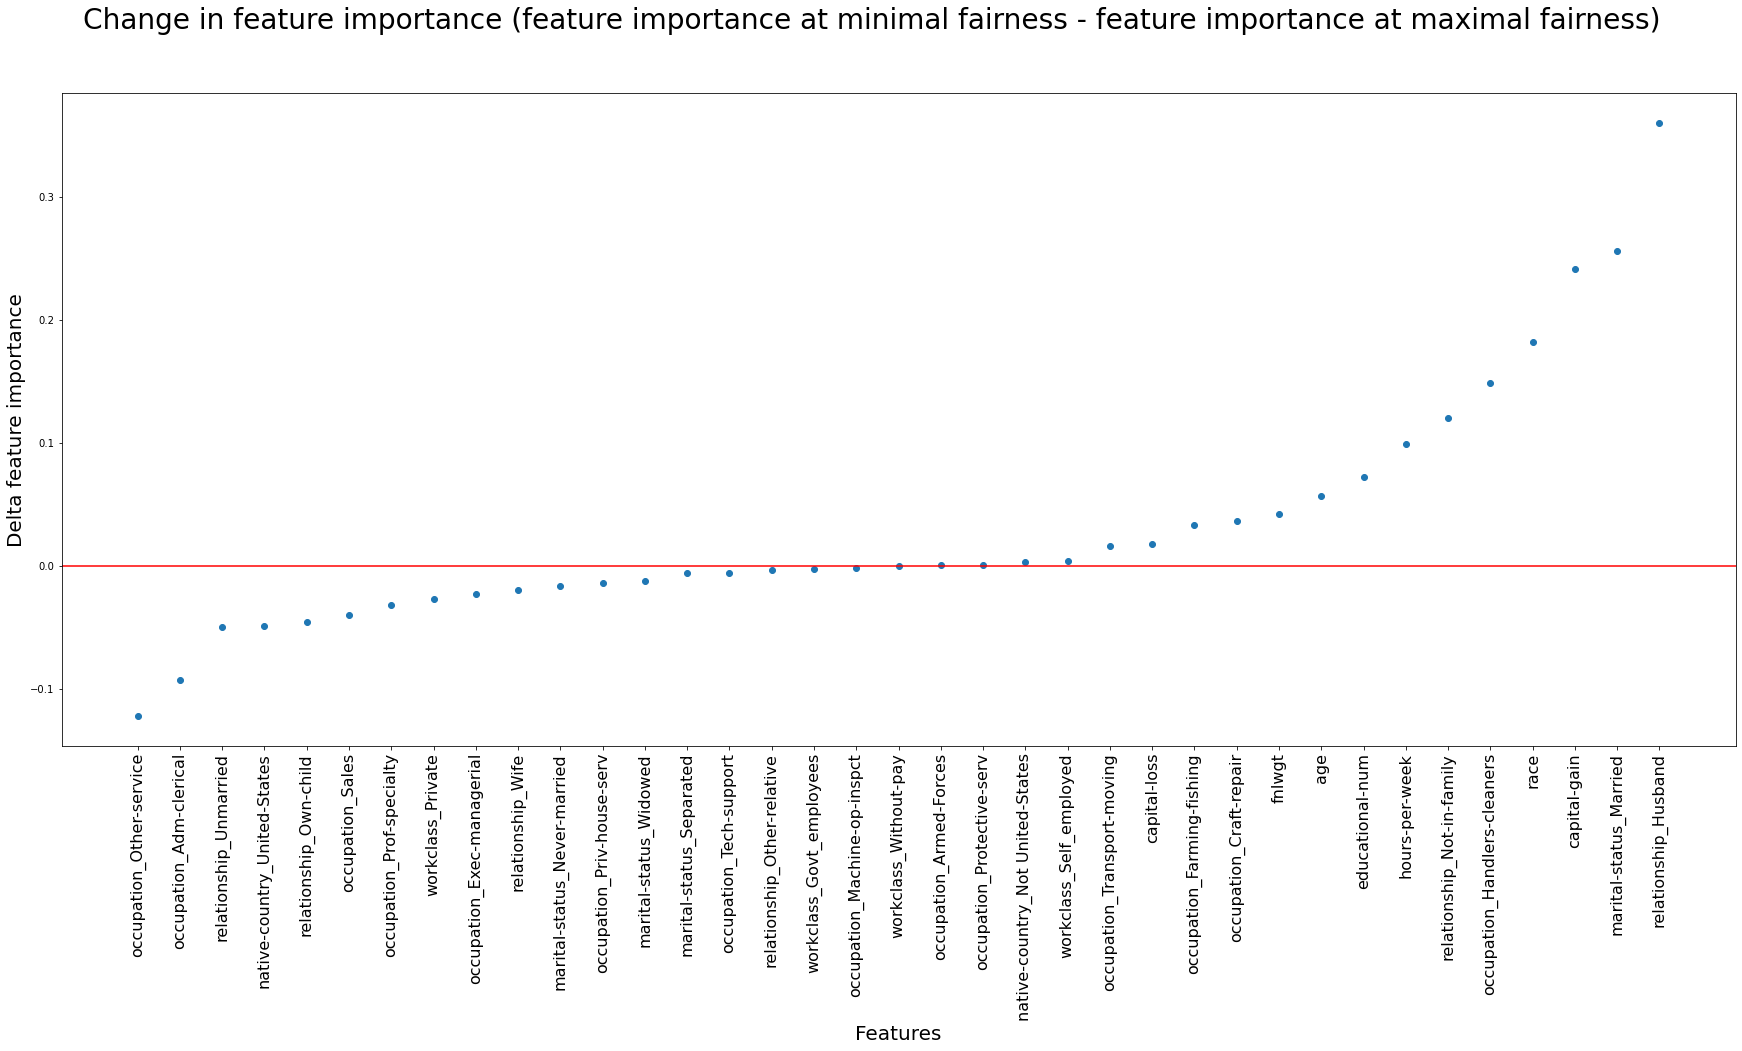

In [466]:
figure, ax = plt.subplots(figsize=(30,12))
ax.scatter(features, delta_importance)
xticks_labels = features
ax.set_xticklabels(xticks_labels, rotation=90, fontsize=16)
figure.suptitle('Change in feature importance (feature importance at minimal fairness - feature importance at maximal fairness)', fontsize=28)
plt.xlabel("Features", fontsize=20)
plt.ylabel('Delta feature importance', fontsize=20)
ax.axhline(y=0, color="red")
plt.show()

### Interpreting these results

The above plot shows which features exhibit the greatest change in feature importance between a model achieving minimal fairness vs a model achieving maximal fairness, relative to gender. This means that features that exhibit measureable positive change, such as relationship_Husband, are given less importance in the fair model than they were in the unfair model:

In [464]:
print('Relationship Husband feature importance for unfair model = ', feature_dict['relationship_Husband'][39][1], '\n fairness score =', feature_dict['relationship_Husband'][39][2])

Relationship Husband feature importance for unfair model =  0.4364293871812866 
 fairness score = 0.2996007429257564


In [465]:
print('Relationship Husband feature importance for fair model = ', feature_dict['relationship_Husband'][0][1], '\n fairness score =', feature_dict['relationship_Husband'][0][2])

Relationship Husband feature importance for fair model =  0.07638135449359099 
 fairness score = 0.7970393761917376


We see that relationship Husband intially had a feature importance of 0.436 in the unfair model, compared to a much lower feature importance of 0.07638 in the fair model.

Thus, we can interpret features that exhibit measureable positive change in the above plot as the features that were contributing to the bias in the biased model.

Now that we have insight into which features are contributing to fairness violations, lets plot out the feature importances of these features as a function of fairness:

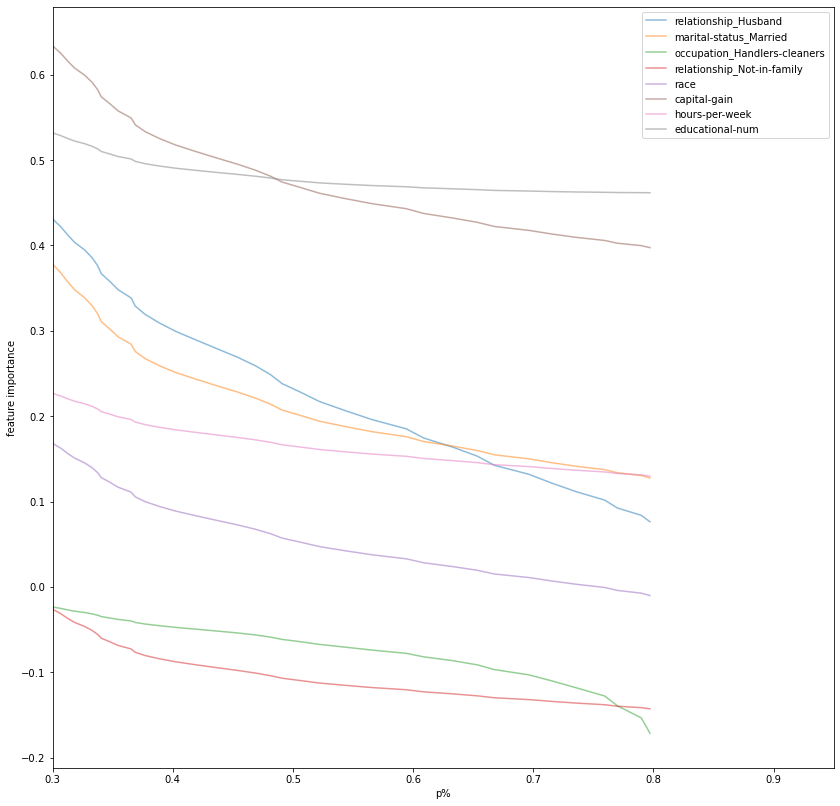

In [497]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(14,14))

for feature in ['relationship_Husband', 'marital-status_Married', 'occupation_Handlers-cleaners', 'relationship_Not-in-family', 'race', 'capital-gain', 'hours-per-week', 'educational-num']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    ax.plot(xs,ys,alpha=0.5, label=feature)

plt.xlabel("p%")
plt.ylabel('feature importance')
plt.xlim((0.3, 0.95))
ax.legend()
ax.set_xlabel("p%")
ax.set_ylabel("feature importance")
ax.tick_params(labelbottom=True)
# ax[0].legend()
# ax[0].set_xlabel("p%")
# ax[0].set_ylabel("feature importance")
# ax[0].tick_params(labelbottom=True)

# for feature in ['occupation_Sales', 'relationship_Own-child', 'native-country_United-States', 'relationship_Unmarried', 'occupation_Adm-clerical', 'occupation_Other-service']:
#     xs = [x[2] for x in feature_dict[feature]]
#     ys = [x[1] for x in feature_dict[feature]]
#     ax[1].plot(xs,ys,label=feature)
# ax[1].legend()
# ax[1].set_xlabel("p%")
# ax[1].set_ylabel("feature importance")
# ax[1].tick_params(labelbottom=True)

## Approach 2: Fairness Decomposition based on Model Difference Regression

As shown in the above benchmark results, we have two different logisitic regression models which achieved drastically different fairness scores relative to gender. The first model, which we will refer to as the biased model, is the original logisitic regression model, which achieved a fairness score of 0.287 relative to gender. The second model, which we will refer to as the debiased model, is a logisitic regression model with a fairness constraint on gender, which achieved a fairness score of 0.797 relative to gender. Note: 0.797 is the maximal fairness score I was able to achieve using the demographic parity classifier (logisitic regression with fairness constraint), which is why we are using this as our debiased model. 

The goal of this fairness decomposition is to create a decomposition model that models the log odds of the debiased model using the log odds of the biased model and the original data. We will then use the learned coefficients of this decomposition model to evaluate the contributions of each feature in debiasing. Our decomposition model will take the form of:


$$log\ odds_{debiased} \thicksim log\ odds_{biased} + \beta_0 + \beta_1*x_1 + \beta_2*x_2 + \cdots + \beta_n *x_n$$
which is equivalent to:
$$log\ odds_{debiased} - log\ odds_{biased} \thicksim \beta_0 + \beta_1*x_1 + \beta_2*x_2 + \cdots + \beta_n *x_n$$


Because our decomposition model is converting a biased model into a fair model, we can use the learned coefficients of the decomposition model to evalute the contributions of each feature in debiasing using the following metrics, where A represents the outcome class:


x_1  :           beta_1  *  [  Mean( x_1 | A = 0)  -  Mean(  x_1  | A = 1)  ]

x_2  :           beta_2  *  [  Mean( x_2 | A = 0)  -  Mean(  x_2  | A = 1)  ]

...

x_n  :           beta_n  *  [  Mean( x_n | A = 0)  -  Mean(  x_n  | A = 1)  ]


In [174]:
biased_model = LogisticRegression(max_iter=5000)
debiased_model = DemographicParityClassifier(sensitive_cols=['gender'], covariance_threshold=0.0000069)

In [175]:
biased_model.fit(x,y)
debiased_model.fit(x,y)

OneVsRestClassifier(estimator=_DemographicParityClassifier(covariance_threshold=6.9e-06,
                                                           sensitive_cols=['gender']),
                    n_jobs=1)

In [176]:
beta_transpose_biased = np.transpose(biased_model.coef_)
beta_transpose_debiased = np.transpose(debiased_model.coef_)

In [177]:
dpc_data = x.drop('gender', axis=1)

In [179]:
log_odds_biased = x @ beta_transpose_biased
log_odds_debiased = dpc_data @ beta_transpose_debiased

In [180]:
y_mod_diff = log_odds_debiased - log_odds_biased

In [181]:
model_difference = LinearRegression()

In [182]:
model_difference.fit(x, y_mod_diff)

LinearRegression()

In [183]:
model_difference.coef_

array([[-6.87690574e-02, -5.21697387e-02, -9.29050611e-02,
        -2.02182865e-01, -7.49261657e-01, -8.67326291e-01,
        -3.94528365e-02, -1.45608621e-01,  5.85437020e-02,
         9.72139787e-02,  6.01734056e-02, -1.84697437e-01,
        -3.73654905e-01,  9.73012800e-02,  5.90955867e-02,
         3.49843681e-01,  7.19063254e-01, -2.52312853e-01,
        -2.03185089e-01,  1.93359262e-01, -9.05139774e-01,
        -4.07543359e+00,  7.86012737e-02,  1.19061509e+00,
         2.53154661e+00,  2.55790158e-01,  5.83222950e-02,
         3.64359796e-01,  2.17387120e-01, -2.16937385e-01,
        -5.50740718e-01, -3.35123029e-01,  1.08843130e-03,
         4.36743979e-01,  4.18738639e-01, -9.40795607e-03,
        -5.62017665e-02,  5.96135897e-02]])

In [184]:
model_difference.coef_.shape

(1, 38)

In [501]:
feat_dict = {}
for feat in x.columns:
    feat_dict[feat] = []


In [502]:
for coef, feat in zip(model_difference.coef_[0,:], x.columns):
    # [Mean( x_n | A = 0) - Mean( x_n | A = 1)]
    mean_feat_given_class_diff = df[feat].loc[df['income'] == 0].mean() - df[feat].loc[df['income'] == 1].mean()
    feat_dict[feat].append(coef*mean_feat_given_class_diff)
    

In [504]:
mod_diff_df = pd.DataFrame.from_dict(feat_dict, orient='index', columns=['feature contribution'])
mod_diff_df.sort_values(by=['feature contribution'], ascending=False)

,feature contribution
capital-gain,0.443153
relationship_Husband,0.253983
marital-status_Married,0.189717
gender,0.176233
occupation_Other-service,0.140575
relationship_Own-child,0.079926
hours-per-week,0.076834
educational-num,0.071620
occupation_Adm-clerical,0.052945
relationship_Unmarried,0.043613


## Interpreting these results

These results imply that capital-gain, relationship_Husband, and marital-status_Married are contributing the most to fairness violations in the original debiased model, which is consistent with the results of the above approach. That being said, it's surprising to me that there are features that have higher contributions than gender (capital-gain, relationship_Husband, marital-status_Married) for fairness violations relative to gender. This could be due to the scaling methods I used in preprocessing, but I'm not entirely sure yet. In any case, I think it's worth exploring further.

It's also interesting that the results of this approach seem to imply that the occupation_Handlers-cleaners is the feature that contributes the most to fairness (not fairness violations), which is not at all consistent with the above approach. In fact, it is the opposite of what the above approach implied. It's worth noting that the shapley value approach also showed this result with regards to occupation_Handlers-cleaners (I removed that approach from the jupyter notebook because I didn't feel that I had a deep enough understanding of shapley values to be able to talk about the implications comfortably, though I plan to add it back in after I do more research).

## Quick analysis of Occupation_Handlers-cleaners

Occupation_Handlers-cleaners is a binary variable, where 1 indicates that the individual's occupation is Handlers-cleaners, and 0 indicates that it is not their occupation

In [505]:
len(df[df['occupation_Handlers-cleaners'] == 1])

1958

In [506]:
len(df)

43131

We see that out of the 43131 individuals in the dataset, 1958 are Handlers-cleaers

In [507]:
len(df[df['occupation_Handlers-cleaners'] == 1].loc[df['gender']==1])

1722

Furthermore, of the 1958 individuals that are Handlers-cleaners, 1722 are males, which is 88%. This suggests its a pretty strong indicator of gender. 

In [519]:
len(df[df['occupation_Handlers-cleaners'] == 1].loc[df['race']==1])

1706

We also see that 1706/1958 occupation_Handlers-cleaners are white, which suggest it is also a pretty strong indicator of race.

Let's see how the biased model and debiased model's predictions of occupation_Handlers-cleaners differ:

In [508]:
# biased model
log_clf = LogisticRegression(max_iter=5000)
log_clf.fit(x,y)
handlers_pred_biased = log_clf.predict(x[x['occupation_Handlers-cleaners']==1])

In [510]:
df_handlers_biased = pd.DataFrame(data=handlers_pred_biased)
df_handlers_biased.value_counts()

0    1929
1      29
dtype: int64

We see that the biased model predicted that 29 of the 1958 occupation_Handlers-cleaners made over 50K

In [511]:
fair_clf = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=0)
fair_clf.fit(x,y)
handlers_pred_fair = fair_clf.predict(x[x['occupation_Handlers-cleaners']==1])

In [512]:
df_handlers_fair = pd.DataFrame(data=handlers_pred_fair)
df_handlers_fair.value_counts()

0    1956
1       2
dtype: int64

We see that the fair model predicted that only 2 of the 1958 handlers-cleaners made over 50K

Given that occupation_Handlers-cleaners is a pretty strong indicator of being male, the results of this latest approach regarding occupation_Handlers-cleaners still do not make sense to me. Will have to do further investigation